In [2]:
import numpy as np
import sklearn as skl
from sklearn.datasets import make_regression
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf

In [3]:
#lire notre banque de données en mettant la date en index
data=pd.read_csv('preprocessed_CAC40.csv',index_col='Date',parse_dates=True)

In [4]:
#On visualise le début de notre dataset.
data.head()

,Unnamed: 0,Name,Open,Closing_Price,Daily_High,Daily_Low,Volume
Date,,,,,,,
2020-04-03,0,Accor,22.99,23.40,23.40,22.99,67
2020-04-02,1,Accor,23.91,22.99,23.91,22.99,250
2020-04-01,2,Accor,24.10,23.83,24.10,23.83,37
2020-03-31,3,Accor,25.04,25.00,25.24,24.99,336
2020-03-30,4,Accor,26.50,25.02,26.50,24.99,415


In [5]:
#On supprime les colonnes qui nous intéresse pas.
data=data.drop(['Open','Closing_Price','Volume'], axis=1)
data.head()

,Unnamed: 0,Name,Daily_High,Daily_Low
Date,,,,
2020-04-03,0,Accor,23.40,22.99
2020-04-02,1,Accor,23.91,22.99
2020-04-01,2,Accor,24.10,23.83
2020-03-31,3,Accor,25.24,24.99
2020-03-30,4,Accor,26.50,24.99


In [6]:
#On enlève les lignes avec le Daily_High vide
data=data.dropna(axis=0)
data.describe()

,Unnamed: 0,Daily_High
count,97444.000000,97444.000000
mean,48760.539099,69.145090
std,28176.457654,77.646032
min,0.000000,3.410000
25%,24369.750000,24.960000
50%,48732.500000,47.160000
75%,73094.250000,82.220000
max,97647.000000,724.000000


In [7]:
#On récupère les Daily_High pour l'entreprise Sanofi comme valeurs d'entraînement
entreprise = data[data['Name'] == 'Sanofi']
dHigh_serie = entreprise['Daily_High']
train_values = dHigh_serie.values

In [8]:
# On normalise les données
min_max_scaler = MinMaxScaler()
# définir le scaler à partir de l'ensemble des données
scaler = min_max_scaler.fit(train_values.reshape(-1, 1))
# mise à l'échelle des données d'apprentissage et de test
# on utilise les 2000 premières valeurs pour l'entraînement
train_values = scaler.transform(dHigh_serie.values[:2000].reshape(-1, 1))
# et le reste des valeurs pour tester la prédiction
test_values = scaler.transform(dHigh_serie.values[2000:].reshape(-1, 1))

In [9]:
def create_window(dataset, start_index, end_index, history_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset)

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i])

    return np.array(data), np.array(labels)

In [10]:
train_features, train_labels = create_window(train_values, 0, None, 5)
test_features, test_labels = create_window(test_values, 0, None, 5)

In [11]:
# On crée des datasets à partir des fenêtres de données
train_dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).batch(100).repeat()
test_dataset = tf.data.Dataset.from_tensor_slices((test_features, test_labels)).batch(100).repeat()

In [12]:
# Notre réseau de neurones utilisant une couche LSTM (Long Short Term Memory)
model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=(5, 1)),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

In [13]:
history = model.fit(
    train_dataset,
    epochs=100,
    steps_per_epoch=20,
    validation_data=test_dataset,
    validation_steps=3
)

Epoch 1/100
20/20 [==============================] - 2s 114ms/step - loss: 0.1090 - val_loss: 9.9311e-04
Epoch 2/100
20/20 [==============================] - 0s 9ms/step - loss: 0.0356 - val_loss: 0.0071
Epoch 3/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0063 - val_loss: 0.0191
Epoch 4/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0031 - val_loss: 0.0206
Epoch 5/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0028 - val_loss: 0.0177
Epoch 6/100
20/20 [==============================] - 0s 8ms/step - loss: 0.0027 - val_loss: 0.0165
Epoch 7/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0026 - val_loss: 0.0157
Epoch 8/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0024 - val_loss: 0.0147
Epoch 9/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0023 - val_loss: 0.0137
Epoch 10/100
20/20 [==============================] - 0s 7ms/step - loss: 0.0022 - val_loss: 0.0127
Epo

In [14]:
def plot_history(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.15])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.show()

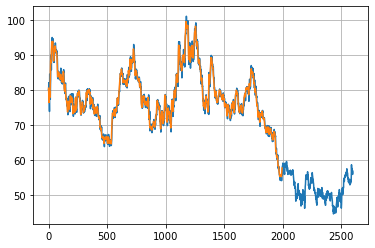

In [15]:
predictions = model.predict(train_features)
unorm = np.reshape(scaler.inverse_transform(predictions), -1)
plt.plot(dHigh_serie.values[:3000])
plt.grid(True)
plt.plot(unorm[:3000])
plt.show()

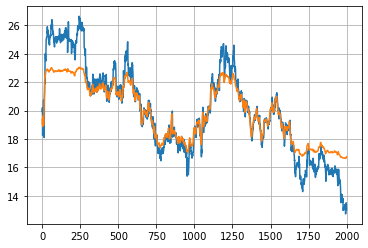

In [22]:
# Nouvelle prédiction

dataframe=pd.read_csv('preprocessed_CAC40.csv',index_col='Date',parse_dates=True)
dataframe = data[data['Name'] == 'Vivendi']
dHigh_series = dataframe['Daily_High']
train_values = dHigh_series.values.reshape(-1, 1)

min_max_scaler = MinMaxScaler()
scaler = min_max_scaler.fit(train_values[:10])
train_values = scaler.transform(train_values)
train_features, train_labels = create_window(train_values, 0, None, 5)

predictions = model.predict(train_features)
unorm = np.reshape(scaler.inverse_transform(predictions), -1)
plt.plot(dHigh_series.values[:2000])
plt.grid(True)
plt.plot(unorm[:2000])
plt.show()